Ilona Smith - 2471308\
Luca von Mayer - 2427051\
Tumi Jourdan - 2180153\
Tao Yuan - 2332155

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import fiona
import shapely
import geopandas
import seaborn as sns
#import sklearn.cluster.DBSCAN
from datetime import datetime

def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [14]:
df = pd.read_csv('nyc_taxis.csv', low_memory=False)

In [15]:
#Question 2

# 1. Distance of trip
df['trip_distance_km'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'],
                                      df['dropoff_longitude'], df['dropoff_latitude'])

# 2. Day of the week
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['day_of_week'] = df['pickup_datetime'].dt.day_name()

# 3. Average speed of trip
# Convert trip duration from seconds to hours
df['trip_duration_hours'] = df['trip_duration'] / 3600
df['average_speed_kmh'] = df['trip_distance_km'] / df['trip_duration_hours']

# Display the first few rows to check the new features
print(df[['trip_distance_km', 'day_of_week', 'average_speed_kmh']].head())

   trip_distance_km day_of_week  average_speed_kmh
0          1.497580      Monday          11.848984
1          1.804374      Sunday           9.797504
2          6.381090     Tuesday          10.815406
3          1.484566   Wednesday          12.457894
4          1.187842    Saturday           9.830418


In [19]:
#Question 3
#1
dfCopy = df.copy()
dfCopy['day_of_week'] = df['day_of_week']
sns.histplot(dfCopy['day_of_week'], bins=7, discrete=True, kde=False, color='blue')



<Figure size 1000x1600 with 0 Axes>

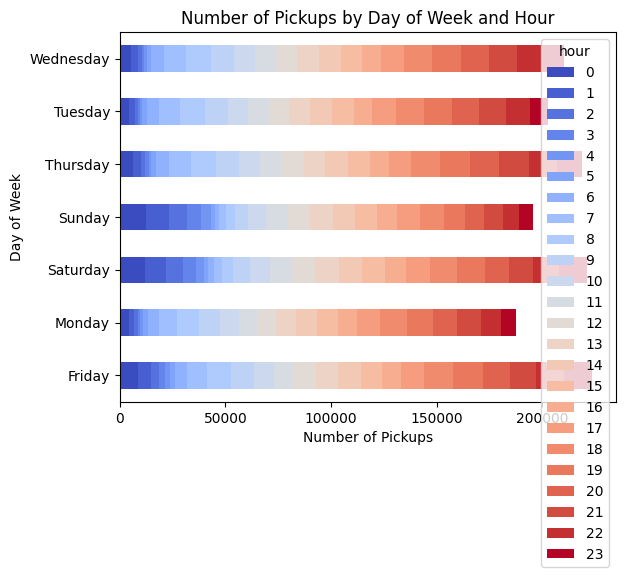

In [22]:
#2
df.head(3)
dfCopy = df.copy()

# Extract hour from pickup_datetime
dfCopy['hour'] = dfCopy['pickup_datetime'].dt.hour

# Group by day_of_week and hour, and count occurrences
times = dfCopy.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Plotting the data
plt.figure(figsize=(10, 16))
times.plot(kind='barh', stacked=True, colormap='coolwarm')
plt.title('Number of Pickups by Day of Week and Hour')
plt.xlabel('Number of Pickups')
plt.ylabel('Day of Week')
plt.show()

In [ ]:
#2